<a href="https://colab.research.google.com/github/Quokka0903/TIL/blob/master/240909_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 딥러닝을 이용한 손글씨 분류기

#딥러닝을 이용한 심장질환 분류기

데이터 설명
- age: 환자의 나이
- sex: 환자의 성별 (1: 남성, 0: 여성)
- cp: 가슴 통증 유형 (chest pain type)
- trestbps: 안정시 혈압 (resting blood pressure)
- chol: 혈청 콜레스테롤 수치 (serum cholesterol)
- fbs: 공복 혈당 수치 (fasting blood sugar)
- restecg: 안정시 심전도 결과 (resting electrocardiographic results)
- thalach: 최대 심박동 수 (maximum heart rate achieved)
- exang: 운동 유발 협심증 여부 (exercise induced angina)
- oldpeak: 운동으로 인한 ST depression
- slope: 운동의 기울기
- ca: 주요 혈관의 수 (number of major vessels colored by fluoroscopy)
- thal: Thalassemia 유형 (thalassemia type)
- target(0,1) : 0=심장질환없음, 1=심장질환있음

Module import & data load

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# 데이터 로드
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
df = pd.read_csv(url, names=names, na_values="?")


In [2]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


Data preprocessing

In [3]:
# 결측치 제거
df = df.dropna()

# target 열을 0과 1로 변환
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0) #이부분 전처리 과정 중요!

# 특성과 레이블 분리
X = df.iloc[:, :-1].values
y = df["target"].values

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

<ipython-input-3-7ae472de18c9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0) #이부분 전처리 과정 중요!


데이터 시각화

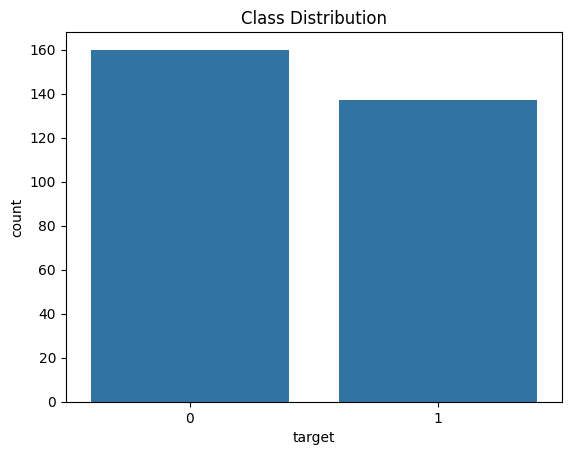

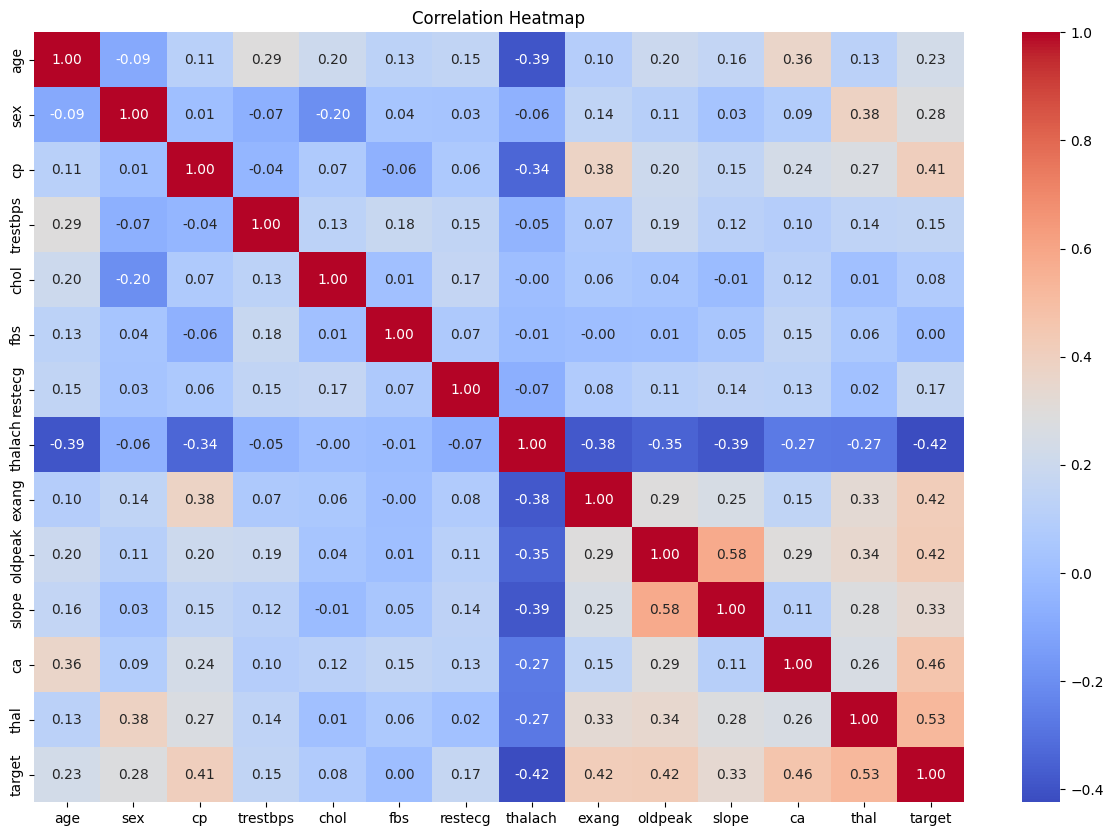

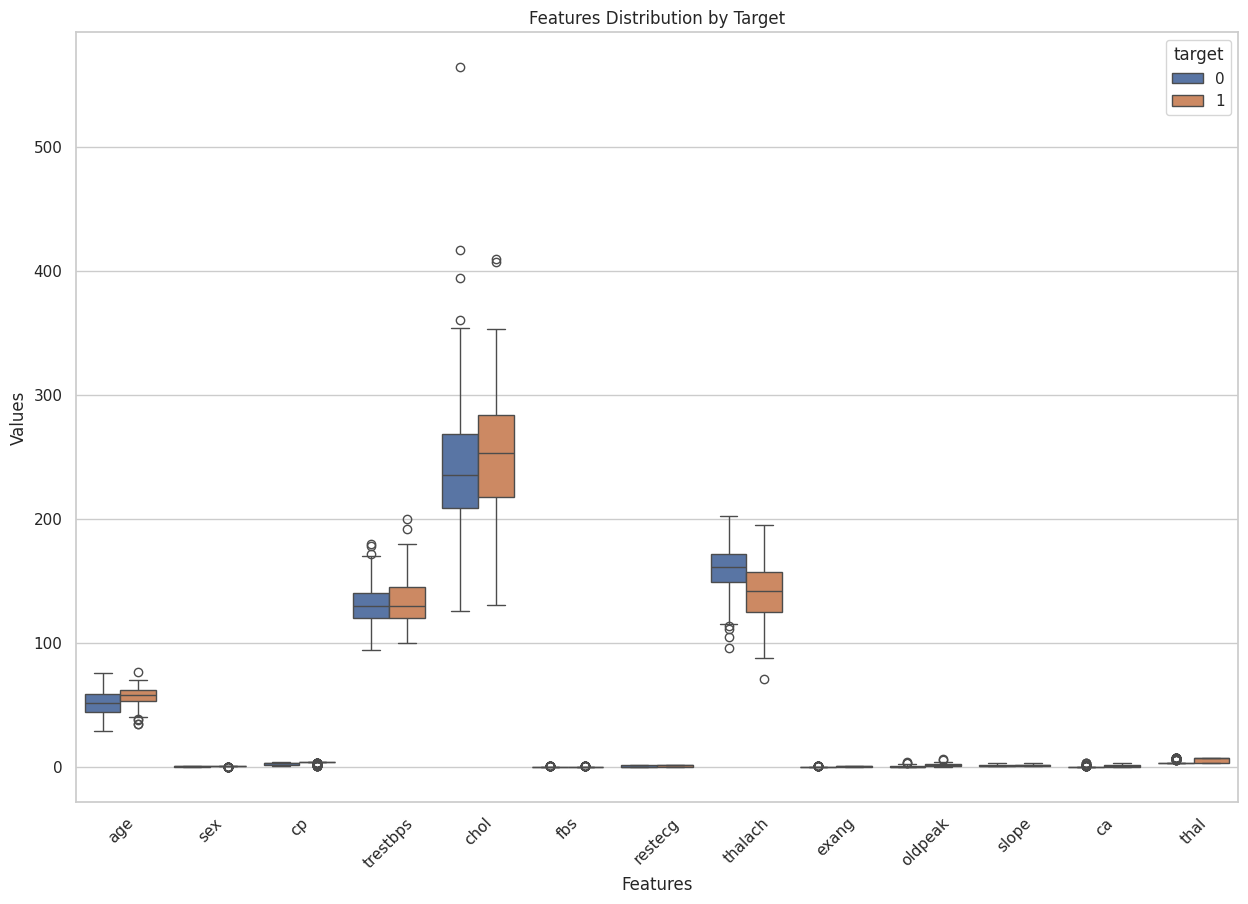

In [4]:
# 클래스 분포 확인
sns.countplot(x='target', data=df)
plt.title('Class Distribution')
plt.show()

# 특성 간 상관관계 시각화
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# 특성별 분포 시각화
sns.set(style="whitegrid")
df_long = pd.melt(df, id_vars="target", var_name="Features", value_name='Values')
plt.figure(figsize=(15, 10))
sns.boxplot(x='Features', y='Values', hue='target', data=df_long)
plt.xticks(rotation=45)
plt.title('Features Distribution by Target')
plt.show()

In [5]:
print(X_train.shape)
print(X_train.shape[1])

(237, 13)
13


Model build

In [6]:
# 케라스 모델 생성
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 훈련
model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4247 - loss: 0.9035 - val_accuracy: 0.3833 - val_loss: 0.8697
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5017 - loss: 0.7115 - val_accuracy: 0.5000 - val_loss: 0.7654
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6482 - loss: 0.6308 - val_accuracy: 0.5333 - val_loss: 0.6916
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6819 - loss: 0.5849 - val_accuracy: 0.6167 - val_loss: 0.6318
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7349 - loss: 0.5681 - val_accuracy: 0.6667 - val_loss: 0.5826
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7834 - loss: 0.5105 - val_accuracy: 0.7167 - val_loss: 0.5372
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7914 - loss: 0.4795 - val_accuracy: 0.7333 - val_loss: 0.4983
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8581 - loss: 0.4200 - val_accuracy: 0.7667 - val_loss

Model test

In [7]:
# 테스트 데이터에서 성능 평가
print(model.predict(X_test))
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
[[0.06706399]
 [0.24673082]
 [0.00768904]
 [0.998876  ]
 [0.02313845]
 [0.23596238]
 [0.15781206]
 [0.70851666]
 [0.92183936]
 [0.086247  ]
 [0.44780043]
 [0.04382225]
 [0.04846973]
 [0.26480746]
 [0.47713426]
 [0.00623286]
 [0.06502233]
 [0.5751961 ]
 [0.38196304]
 [0.07549435]
 [0.7148221 ]
 [0.835098  ]
 [0.7532453 ]
 [0.07903971]
 [0.8999334 ]
 [0.03637583]
 [0.9870556 ]
 [0.6870304 ]
 [0.16686666]
 [0.01482178]
 [0.0181172 ]
 [0.0097143 ]
 [0.9883664 ]
 [0.12084673]
 [0.06325743]
 [0.17183872]
 [0.718433  ]
 [0.05697514]
 [0.9954829 ]
 [0.9264242 ]
 [0.08650497]
 [0.96813506]
 [0.99160624]
 [0.40600628]
 [0.01575901]
 [0.21934073]
 [0.30011162]
 [0.98880863]
 [0.57228124]
 [0.02118897]
 [0.04001613]
 [0.9288773 ]
 [0.13279784]
 [0.14251362]
 [0.9850086 ]
 [0.7357338 ]
 [0.07554246]
 [0.13301879]
 [0.85425836]
 [0.9677165 ]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8479 - loss: 0.3086
Test Loss: 0.3253149688243866, Test Accuracy: 0.8

# 부동산 가격 예측

문제 정의:
부동산과 관련된 여러 데이터를 가지고 부동산의 가격을 예측하는 회귀 모델 설계

데이터 정의

특징 변수:
- CRIM: 인구 1인당 범죄율
- ZN: 25,000 평방 피트 이상의 주거 구역 비중
- INDUS: 소매업 외 상업이 차지하는 면적 비율
- CHAS: 찰스 강(Charles River)에 대한 더미 변수 (강 주변이면 1, 아니면 0)
- NOX: 일산화질소 농도
- RM: 주택당 평균 방 수
- AGE: 1940년 이전에 건축된 주택의 비율
- DIS: 5개의 보스턴 고용 센터까지의 가중 거리
- RAD: 순환고속도로 접근성 지수
- TAX: $10,000당 부동산 세율
- PTRATIO: 학생-교사 비율
- B: 흑인 비율
- LSTAT: 저소득층의 비율

타겟 변수 (종속 변수):
- MEDV: 주택의 중간 가격 (1,000 달러 단위)


Module import & data preprocessing

In [ ]:
from keras.datasets import boston_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 보스턴 주택 가격 데이터셋 로드
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

# 데이터 전처리: 표준화 (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 데이터 분할: 훈련 데이터와 검증 데이터
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)


57026/57026 [==============================] - 0s 0us/step


In [ ]:
print(X_train_split.shape)

(323, 13)


Model build & training

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# 모델 정의
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=1, activation='linear'))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history = model.fit(X_train_split, y_train_split, epochs=100, batch_size=32,validation_data=(X_val_split, y_val_split), verbose=1)


Epoch 1/100
11/11 [==============================] - 1s 20ms/step - loss: 621.0773 - val_loss: 472.8613
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 605.3258 - val_loss: 460.8462
Epoch 3/100
11/11 [==============================] - 0s 6ms/step - loss: 590.0118 - val_loss: 448.8569
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 574.1871 - val_loss: 436.5981
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 557.7692 - val_loss: 423.7661
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 539.9866 - val_loss: 410.2433
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 520.8132 - val_loss: 395.8371
Epoch 8/100
11/11 [==============================] - 0s 6ms/step - loss: 500.8273 - val_loss: 380.9297
Epoch 9/100
11/11 [==============================] - 0s 6ms/step - loss: 479.6977 - val_loss: 364.9025
Epoch 10/100
11/11 [==============================] - 0s 6ms/step - loss

Model test

In [ ]:
# 모델 평가
mse_train = model.evaluate(X_train_scaled, y_train, verbose=0)
mse_test = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Training Mean Squared Error: {mse_train}')
print(f'Test Mean Squared Error: {mse_test}')

# 새로운 데이터에 대한 예측
new_data = X_test_scaled[:5]  # 예제로 처음 5개의 데이터 사용
predictions = model.predict(new_data)

print("\nPredictions:")
for i in range(5):
    print(f"Prediction: {predictions[i][0]:.2f}, Actual: {y_test[i]:.2f}")


Training Mean Squared Error: 19.580419540405273
Test Mean Squared Error: 26.924957275390625
1/1 [==============================] - 0s 115ms/step

Predictions:
Prediction: 9.67, Actual: 7.20
Prediction: 17.14, Actual: 18.80
Prediction: 20.31, Actual: 19.00
Prediction: 32.53, Actual: 27.00
Prediction: 26.31, Actual: 22.20


# 자동차 연비 예측

문제 정의:
자동차의 여러 데이터를 가지고 연비를 예측하는 회귀 모델 설계

데이터 정의:

특징 변수:
- Cylinders: 엔진 실린더의 수를 나타내는 특징으로, 자동차의 성능과 효율성에 영향을 미칩니다.

- Displacement: 엔진의 배기량을 나타내는 특징으로, 자동차의 크기와 연비에 영향을 미칩니다.

- Horsepower: 자동차의 마력을 나타내는 특징으로, 성능과 연비에 영향을 미칩니다.

- Weight: 자동차의 무게를 나타내는 특징으로, 연비에 영향을 미치는 중요한 요소 중 하나입니다.

- Acceleration: 0에서 60 mph까지 가속하는데 걸리는 시간을 나타내는 특징으로, 성능과 연비에 영향을 미칩니다.

- Model Year: 자동차 모델의 제조 연도를 나타내는 특징으로, 연식에 따라 기술적인 특성이 변할 수 있습니다.

- Origin: 자동차의 제조 국가를 나타내는 특징으로, 범주형 데이터입니다. 이 데이터셋에서는 1, 2, 3으로 표현되며 각각 미국, 유럽, 일본을 나타냅니다.

타겟 변수:
- MPG (Miles Per Gallon): 주행거리 당 연료 소비량을 나타내는 특징으로, 자동차의 연비를 나타냅니다.


Module import & data load

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

# 데이터 로드
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_data = pd.read_csv(url, delim_whitespace=True, names=column_names, na_values='?', comment='\t', skipinitialspace=True)

# 'Origin' 특징에 대한 원-핫 인코딩 적용
data = pd.get_dummies(raw_data, columns=['Origin'], prefix='Origin')

# 누락된 데이터 제거
data = data.dropna()

# 특징과 레이블 분리
X = data.drop('MPG', axis=1)
y = data['MPG']

# 데이터 전처리: 표준화 (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할: 훈련 데이터와 검증 데이터
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

데이터 시각화

In [ ]:
# 신경망 모델
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# 예측 및 평가
y_pred_nn = model.predict(X_val)
mse_nn = mean_squared_error(y_val, y_pred_nn)
print(f'Mean Squared Error (Neural Network): {mse_nn:.2f}')

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 49.1071
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.9678 
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.8887 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.0767 
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.3255  
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.7513 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8070 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.2074
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0375  
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1186  
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3437 
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1068  
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8960 
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7835
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0

#자전거 대여량 예측

"Bike Sharing Demand" 데이터셋은 Capital Bikeshare에서 제공한 워싱턴 D.C.의 자전거 대여 데이터. 이 데이터셋은 자전거 대여소에서 대여된 자전거의 일일 대여 횟수를 기록한 것이며, 다양한 환경 변수들이 포함되어 있습니다.

데이터셋의 주요 특징 및 타겟 변수에 대한 설명은 다음과 같습니다:

특징 변수 (독립 변수):
- season: 계절 (1: 봄, 2: 여름, 3: 가을, 4: 겨울)
- holiday: 공휴일 여부 (1: 공휴일, 0: 비공휴일)
- workingday: 근무일 여부 (1: 근무일, 0: 휴무일)
- weather: 날씨 상태 (1: 맑음, 2: 흐림, 3: 가벼운 비/눈, 4: 심한 비/눈)
- temp: 온도 (섭씨)
- atemp: 체감 온도 (섭씨)
- humidity: 상대 습도
- windspeed: 풍속

타겟 변수 (종속 변수):
- count: 대여 횟수

모듈 import 및 data load

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, load_model
from keras.layers import Dense

# Bike Sharing Demand 데이터셋 로드 (train.csv 파일 사용)
csv_path = "bike_train.csv"
data = pd.read_csv(csv_path)

데이터 전처리

In [ ]:
# 필요한 특징과 타겟 변수 선택
features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
target = 'count'

# 특징과 타겟 변수 추출
X = data[features]
y = data[target]

In [ ]:
# 범주형 데이터에 대한 원-핫 인코딩
X_categorical = pd.get_dummies(X, columns=['season', 'holiday', 'workingday', 'weather'], drop_first=True)

# 수치형 데이터 추출
X_numeric = X[['temp', 'atemp', 'humidity', 'windspeed']]

# 데이터 합치기
X_processed = pd.concat([X_categorical, X_numeric], axis=1)

In [ ]:
# 데이터 전처리: 표준화 (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)

# 데이터 분할: 훈련 데이터와 검증 데이터
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Model 정의 및 학습

In [ ]:
# 모델 정의
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 훈련
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

# 모델 저장
model.save("bike_sharing_model.h5")
print("모델이 저장되었습니다.")

# 저장한 모델 불러오기
loaded_model = load_model("bike_sharing_model.h5")
print("모델을 성공적으로 불러왔습니다.")

# 저장한 모델로 예측 수행
y_pred = loaded_model.predict(X_val)

# 예측 결과 출력
print("\n대여 횟수 예측 결과:")
print("실제 값\t\t\t\t예측 값")
for true_val, pred_val in zip(y_val[:5], y_pred[:5]):
    print(f"{true_val}\t\t\t{pred_val[0]:.4f}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


273/273 - 2s - 6ms/step - loss: 66754.7656 - val_loss: 62154.0000
Epoch 2/50
273/273 - 1s - 4ms/step - loss: 52847.2227 - val_loss: 43006.4805
Epoch 3/50
273/273 - 2s - 6ms/step - loss: 35497.2578 - val_loss: 30648.7891
Epoch 4/50
273/273 - 1s - 4ms/step - loss: 28546.6289 - val_loss: 27193.1719
Epoch 5/50
273/273 - 1s - 4ms/step - loss: 26421.6992 - val_loss: 25755.8008
Epoch 6/50
273/273 - 1s - 3ms/step - loss: 25355.3379 - val_loss: 24945.0820
Epoch 7/50
273/273 - 1s - 5ms/step - loss: 24736.4766 - val_loss: 24490.3242
Epoch 8/50
273/273 - 1s - 5ms/step - loss: 24377.4297 - val_loss: 24285.1055
Epoch 9/50
273/273 - 1s - 4ms/step - loss: 24175.1230 - val_loss: 24047.6426
Epoch 10/50
273/273 - 1s - 5ms/step - loss: 24019.7910 - val_loss: 23895.4219
Epoch 11/50
273/273 - 1s - 5ms/step - loss: 23906.5312 - val_loss: 23775.0625
Epoch 12/50
273/273 - 2s - 7ms/step - loss: 23818.6348 - val_loss: 23679.0039
Epoch 13/50
273/273 - 3s - 10ms/step - loss: 23739.2891 - val_loss: 23592.3008
Epoch

모델이 저장되었습니다.
모델이 불러와졌습니다.
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

대여 횟수 예측 결과:
실제 값				예측 값
127			290.6742
13			1.4846
163			163.8287
233			260.2145
222			270.7333


#과제 예시

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 28, 28), dtype=float32). Expected shape (None, 784), but input has incompatible shape (None, 28, 28)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 28, 28), dtype=float32)
  • training=True
  • mask=None

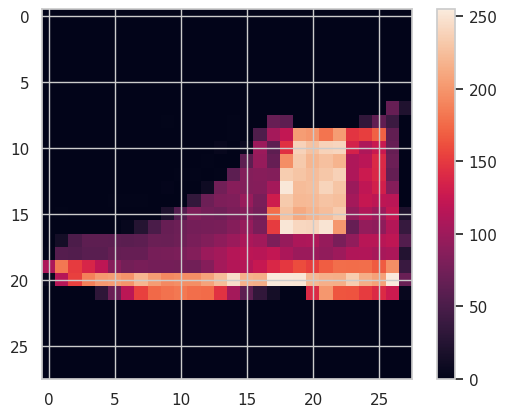

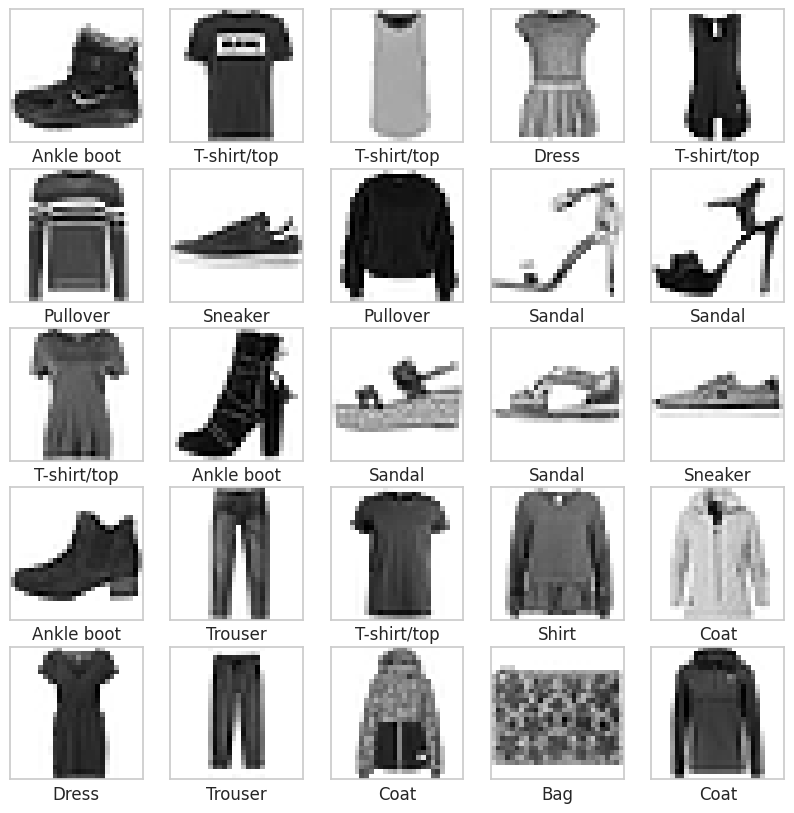

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

##Fashion MNIST 데이터셋 불러오기
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure()
plt.imshow(train_images[111])
plt.colorbar()
plt.grid(True)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

#데이터 스케일링
train_images = train_images / 255.0
test_images = test_images / 255.0

# 모델 구성
model=Sequential()
#################
## 구현한 부분 ##
model.add(Dense(128, activation='relu', input_shape=(28*28,)))  # 첫 번째 은닉층
model.add(Dense(10, activation='softmax'))  # 출력층
#################
model.summary()

# 모델 컴파일 및 학습
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10, batch_size=64, verbose=1)

## 모델 테스트
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

predictions = model.predict(test_images)

print(predictions[0])
print(np.argmax(predictions[0]))

In [ ]:
# 모델 구성
model=Sequential()
#################
## 이부분 구현 ##
#################
model.summary()

# 모델 컴파일 및 학습
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10, batch_size=64, verbose=1)

## 모델 테스트
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

predictions = model.predict(test_images)

print(predictions[0])
print(np.argmax(predictions[0]))
